In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [ ]:
n_variate = 4

In [ ]:

#Load dataset
def load_dataset(path=r'dataset_test_v3.csv'):
  return pd.read_csv(path)

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [ ]:
def prepare_data(df):
  # df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux = df
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux

In [ ]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])

    return scaler

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [ ]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [ ]:
# 1 LSTM, 1 LSTM, 1 Densa, 1 Dropout, 1 Densa
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
    #Add a new layer
    model.add(tf.keras.layers.GRU(32, activation=activation ,return_sequences=False))
    #
    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_variate, activation='linear'))

    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'accidents_model.png', show_shapes=True)
    model.summary()
    return model

In [ ]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [ ]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [ ]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [ ]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(14,6))
  plt.plot(range(len(data)), data['Nr_acidentes'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Nr de Acidentes em Braga')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [ ]:
'''tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 4 },
                2: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 4 },
                3: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 4 },

                #
                4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }'''

tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}

# record da history de cada modelo
record = {}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 64)             13440     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 5s 77ms/step - loss: 0.2761 - mae: 0.2381 - rmse: 0.2762 - val_los

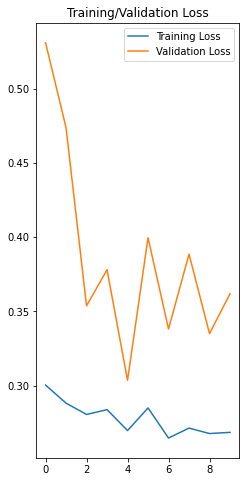

Epoch 1/10
31/31 [==============================] - 2s 10ms/step - loss: 0.3082 - mae: 0.2651 - rmse: 0.3082 - val_loss: 0.2600 - val_mae: 0.2314 - val_rmse: 0.2842
Epoch 2/10
31/31 [==============================] - 0s 7ms/step - loss: 0.3239 - mae: 0.2795 - rmse: 0.3239 - val_loss: 0.2561 - val_mae: 0.2263 - val_rmse: 0.2721
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 0.3037 - mae: 0.2615 - rmse: 0.3037 - val_loss: 0.2745 - val_mae: 0.2443 - val_rmse: 0.2905
Epoch 4/10
31/31 [==============================] - 0s 7ms/step - loss: 0.2988 - mae: 0.2564 - rmse: 0.2988 - val_loss: 0.2577 - val_mae: 0.2282 - val_rmse: 0.2775
Epoch 5/10
31/31 [==============================] - 0s 7ms/step - loss: 0.3076 - mae: 0.2631 - rmse: 0.3076 - val_loss: 0.2732 - val_mae: 0.2451 - val_rmse: 0.2866

Epoch 00005: val_loss improved from 0.30351 to 0.27318, saving model to my_model_5_0.273.h5
Epoch 6/10
31/31 [==============================] - 0s 8ms/step - loss: 0.2929 - mae: 

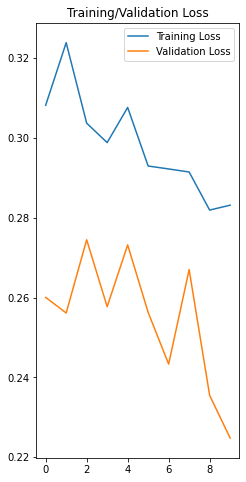

Epoch 1/10
47/47 [==============================] - 1s 24ms/step - loss: 0.2748 - mae: 0.2289 - rmse: 0.2794 - val_loss: 0.5674 - val_mae: 0.4936 - val_rmse: 0.5674
Epoch 2/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2882 - mae: 0.2427 - rmse: 0.2918 - val_loss: 0.5220 - val_mae: 0.4495 - val_rmse: 0.5220
Epoch 3/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2789 - mae: 0.2349 - rmse: 0.2814 - val_loss: 0.4406 - val_mae: 0.3801 - val_rmse: 0.4406
Epoch 4/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2649 - mae: 0.2210 - rmse: 0.2670 - val_loss: 0.3827 - val_mae: 0.3243 - val_rmse: 0.3827
Epoch 5/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2527 - mae: 0.2130 - rmse: 0.2555 - val_loss: 0.3596 - val_mae: 0.2969 - val_rmse: 0.3596

Epoch 00005: val_loss did not improve from 0.22479
Epoch 6/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2514 - mae: 0.2101 - rmse: 0.2539 - val_loss: 0.3570 

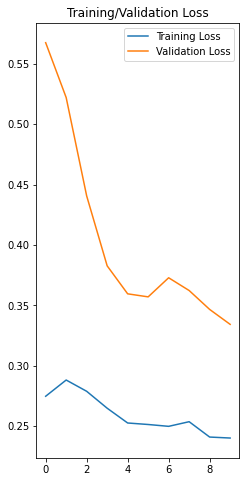

[array([[130.71948 , 123.749306, 131.0247  , 133.68167 ]], dtype=float32), array([[305.18396, 290.534  , 301.82434, 299.43747]], dtype=float32), array([[323.43674, 307.32495, 320.24173, 316.98758]], dtype=float32), array([[301.55908, 287.46573, 298.49213, 297.1098 ]], dtype=float32), array([[336.5959, 323.62  , 333.9968, 330.93  ]], dtype=float32), array([[352.96915, 341.74332, 351.77463, 347.85773]], dtype=float32), array([[262.0553 , 254.11716, 260.50845, 261.6813 ]], dtype=float32), array([[211.13823, 210.54774, 211.50809, 216.72633]], dtype=float32), array([[293.74295, 291.1937 , 289.5437 , 295.95038]], dtype=float32), array([[327.95483, 322.0329 , 322.1105 , 325.4439 ]], dtype=float32), array([[350.69153, 342.68347, 346.1158 , 346.04214]], dtype=float32), array([[363.49817, 355.64444, 361.2758 , 359.64752]], dtype=float32), array([[348.4205 , 342.7682 , 347.5618 , 348.97986]], dtype=float32), array([[283.59198, 281.9615 , 283.72543, 289.2103 ]], dtype=float32), array([[245.38322, 

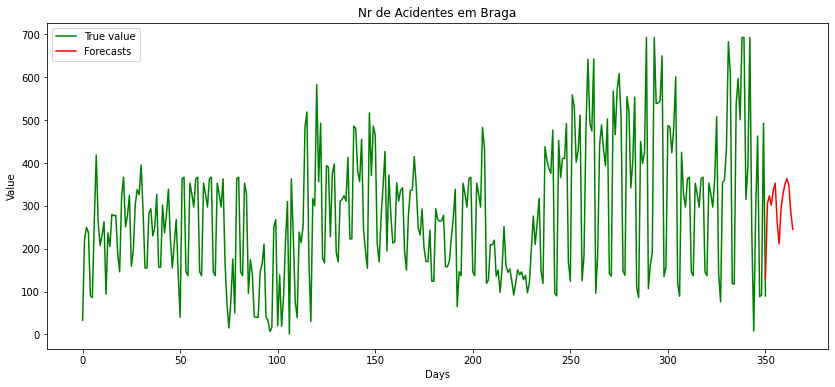

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7, 64)             13440     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 4s 59ms/step - loss: 0.3314 - mae: 0.2866 - rmse: 0.3314 - val_l

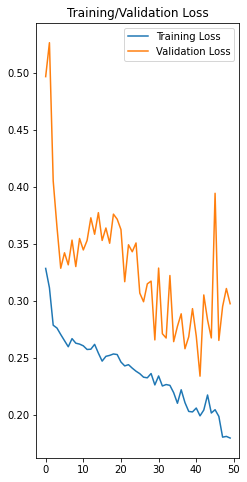

Epoch 1/50
31/31 [==============================] - 2s 9ms/step - loss: 0.2823 - mae: 0.2393 - rmse: 0.2823 - val_loss: 0.2978 - val_mae: 0.2651 - val_rmse: 0.3128
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2708 - mae: 0.2246 - rmse: 0.2708 - val_loss: 0.2168 - val_mae: 0.1854 - val_rmse: 0.2329
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2691 - mae: 0.2235 - rmse: 0.2691 - val_loss: 0.2009 - val_mae: 0.1674 - val_rmse: 0.2073
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2586 - mae: 0.2129 - rmse: 0.2586 - val_loss: 0.2143 - val_mae: 0.1865 - val_rmse: 0.2184
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2408 - mae: 0.1982 - rmse: 0.2408 - val_loss: 0.2212 - val_mae: 0.1896 - val_rmse: 0.2337

Epoch 00005: val_loss improved from 0.26420 to 0.22121, saving model to my_model_5_0.221.h5
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2511 - mae: 0

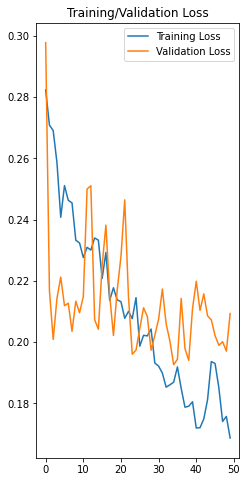

Epoch 1/50
47/47 [==============================] - 1s 24ms/step - loss: 0.2042 - mae: 0.1699 - rmse: 0.2075 - val_loss: 0.3121 - val_mae: 0.2557 - val_rmse: 0.3121
Epoch 2/50
47/47 [==============================] - 0s 9ms/step - loss: 0.2033 - mae: 0.1640 - rmse: 0.2058 - val_loss: 0.3911 - val_mae: 0.3340 - val_rmse: 0.3911
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.1906 - mae: 0.1532 - rmse: 0.1938 - val_loss: 0.3671 - val_mae: 0.3158 - val_rmse: 0.3671
Epoch 4/50
47/47 [==============================] - 0s 10ms/step - loss: 0.1840 - mae: 0.1494 - rmse: 0.1865 - val_loss: 0.3752 - val_mae: 0.3237 - val_rmse: 0.3752
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.1950 - mae: 0.1612 - rmse: 0.1974 - val_loss: 0.3076 - val_mae: 0.2490 - val_rmse: 0.3076

Epoch 00005: val_loss did not improve from 0.19262
Epoch 6/50
47/47 [==============================] - 0s 9ms/step - loss: 0.1881 - mae: 0.1526 - rmse: 0.1903 - val_loss: 0.37

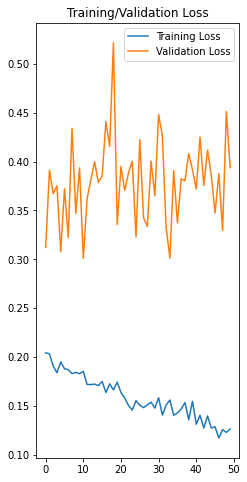

[array([[135.37546, 138.16869, 135.29996, 140.79994]], dtype=float32), array([[485.52853, 483.5701 , 486.50922, 483.86475]], dtype=float32), array([[360.01028, 362.03152, 361.99973, 358.94095]], dtype=float32), array([[221.75482, 225.0337 , 219.78789, 225.79329]], dtype=float32), array([[255.48824, 255.02895, 253.45926, 256.55597]], dtype=float32), array([[396.88477, 397.0495 , 400.65543, 395.8174 ]], dtype=float32), array([[255.83936, 256.23102, 254.43289, 257.42688]], dtype=float32), array([[241.50468, 241.42674, 241.28598, 243.8513 ]], dtype=float32), array([[385.90195, 384.5713 , 386.75723, 387.31873]], dtype=float32), array([[341.558  , 342.36014, 344.31314, 341.33588]], dtype=float32), array([[213.09763, 214.19937, 212.57645, 215.62761]], dtype=float32), array([[315.0916 , 314.5004 , 316.34372, 315.6448 ]], dtype=float32), array([[386.27594, 385.9273 , 389.5269 , 385.63528]], dtype=float32), array([[243.48154, 243.97324, 242.86708, 245.39395]], dtype=float32), array([[277.51422, 

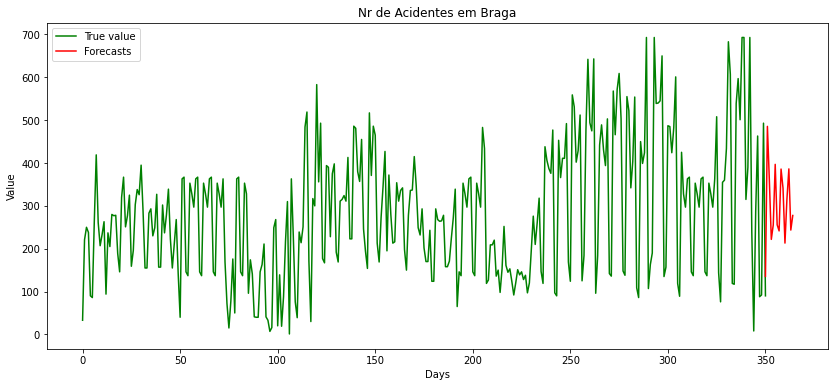

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 7, 64)             13440     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 0.3409 - mae: 0.2947 - rmse: 0.3409 - val_

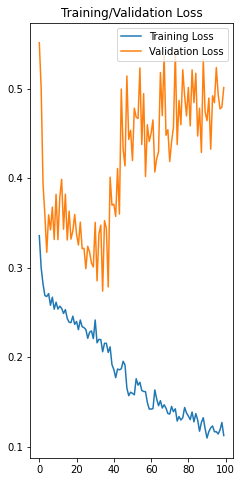

Epoch 1/100
31/31 [==============================] - 2s 10ms/step - loss: 0.2734 - mae: 0.2290 - rmse: 0.2734 - val_loss: 0.2638 - val_mae: 0.2361 - val_rmse: 0.2978
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2745 - mae: 0.2351 - rmse: 0.2745 - val_loss: 0.2508 - val_mae: 0.2223 - val_rmse: 0.2774
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2572 - mae: 0.2136 - rmse: 0.2572 - val_loss: 0.2379 - val_mae: 0.2055 - val_rmse: 0.2646
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2411 - mae: 0.1989 - rmse: 0.2411 - val_loss: 0.2325 - val_mae: 0.2012 - val_rmse: 0.2563
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2385 - mae: 0.1962 - rmse: 0.2385 - val_loss: 0.2349 - val_mae: 0.2053 - val_rmse: 0.2542

Epoch 00005: val_loss improved from 0.27364 to 0.23487, saving model to my_model_5_0.235.h5
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2298 -

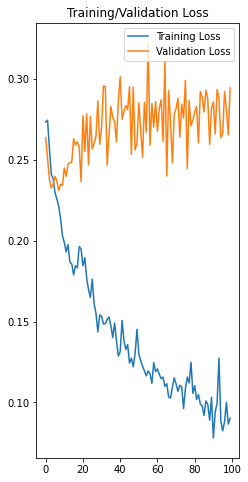

Epoch 1/100
47/47 [==============================] - 1s 26ms/step - loss: 0.1660 - mae: 0.1321 - rmse: 0.1680 - val_loss: 0.4951 - val_mae: 0.4078 - val_rmse: 0.4951
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.1634 - mae: 0.1340 - rmse: 0.1661 - val_loss: 0.4853 - val_mae: 0.4065 - val_rmse: 0.4853
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 0.1486 - mae: 0.1193 - rmse: 0.1508 - val_loss: 0.5090 - val_mae: 0.4070 - val_rmse: 0.5090
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: 0.1513 - mae: 0.1238 - rmse: 0.1536 - val_loss: 0.3781 - val_mae: 0.3150 - val_rmse: 0.3781
Epoch 5/100
47/47 [==============================] - 0s 10ms/step - loss: 0.1371 - mae: 0.1109 - rmse: 0.1392 - val_loss: 0.4477 - val_mae: 0.3613 - val_rmse: 0.4477

Epoch 00005: val_loss did not improve from 0.23423
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: 0.1330 - mae: 0.1050 - rmse: 0.1357 - val_lo

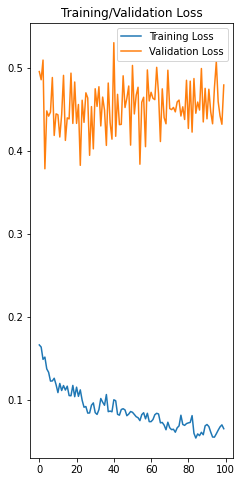

[array([[81.26853 , 81.79851 , 81.84518 , 81.543274]], dtype=float32), array([[358.43176, 358.5713 , 358.26907, 358.20453]], dtype=float32), array([[284.2564 , 284.6048 , 284.43112, 284.27615]], dtype=float32), array([[122.34159 , 122.89883 , 122.79625 , 122.751495]], dtype=float32), array([[128.54051, 128.98874, 128.78148, 128.81306]], dtype=float32), array([[300.32584, 300.29785, 300.2741 , 300.3016 ]], dtype=float32), array([[258.31   , 258.52383, 258.63962, 258.4266 ]], dtype=float32), array([[268.93698, 268.9831 , 268.9462 , 269.11203]], dtype=float32), array([[343.69275, 343.38837, 343.21576, 343.64267]], dtype=float32), array([[238.27054, 238.69931, 238.22108, 238.31044]], dtype=float32), array([[123.8708 , 124.59824, 124.38698, 124.12225]], dtype=float32), array([[172.21155, 172.74834, 172.60866, 172.44843]], dtype=float32), array([[308.90683, 309.07956, 309.0065 , 309.09222]], dtype=float32), array([[295.86716, 296.0154 , 296.02942, 296.21997]], dtype=float32), array([[245.157

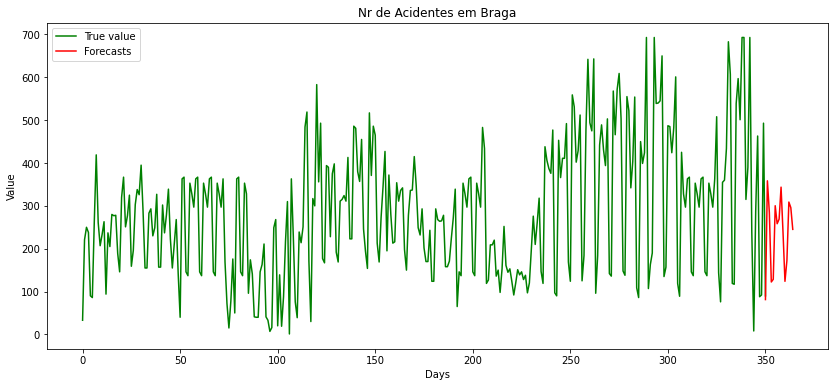

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 8, 64)             13440     
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
16/16 [==============================] - 4s 60ms/step - loss: 0.2977 - mae: 0.2543 - rmse: 0.2978 - val_l

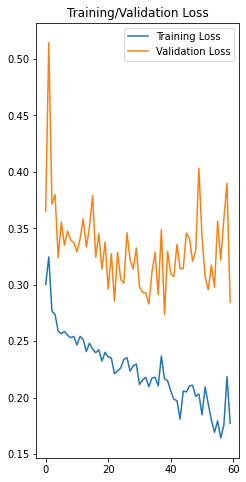

Epoch 1/60
31/31 [==============================] - 0s 14ms/step - loss: 0.2743 - mae: 0.2371 - rmse: 0.2744 - val_loss: 0.2962 - val_mae: 0.2758 - val_rmse: 0.3374
Epoch 2/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2579 - mae: 0.2212 - rmse: 0.2575 - val_loss: 0.2574 - val_mae: 0.2292 - val_rmse: 0.2871
Epoch 3/60
31/31 [==============================] - 0s 13ms/step - loss: 0.2555 - mae: 0.2178 - rmse: 0.2550 - val_loss: 0.2507 - val_mae: 0.2282 - val_rmse: 0.2782
Epoch 4/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2371 - mae: 0.2025 - rmse: 0.2368 - val_loss: 0.2550 - val_mae: 0.2344 - val_rmse: 0.2835
Epoch 5/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2287 - mae: 0.1957 - rmse: 0.2286 - val_loss: 0.2530 - val_mae: 0.2321 - val_rmse: 0.2851

Epoch 00005: val_loss improved from 0.28429 to 0.25300, saving model to my_model_5_0.253.h5
Epoch 6/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2255 - 

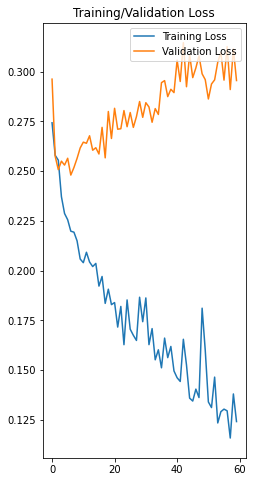

Epoch 1/60
47/47 [==============================] - 1s 27ms/step - loss: 0.1957 - mae: 0.1658 - rmse: 0.1988 - val_loss: 0.4682 - val_mae: 0.3860 - val_rmse: 0.4682
Epoch 2/60
47/47 [==============================] - 1s 11ms/step - loss: 0.2029 - mae: 0.1701 - rmse: 0.2053 - val_loss: 0.4481 - val_mae: 0.3941 - val_rmse: 0.4481
Epoch 3/60
47/47 [==============================] - 1s 11ms/step - loss: 0.1838 - mae: 0.1567 - rmse: 0.1861 - val_loss: 0.4090 - val_mae: 0.3411 - val_rmse: 0.4090
Epoch 4/60
47/47 [==============================] - 1s 11ms/step - loss: 0.1681 - mae: 0.1419 - rmse: 0.1710 - val_loss: 0.4267 - val_mae: 0.3610 - val_rmse: 0.4267
Epoch 5/60
47/47 [==============================] - 1s 12ms/step - loss: 0.1632 - mae: 0.1366 - rmse: 0.1647 - val_loss: 0.4012 - val_mae: 0.3208 - val_rmse: 0.4012

Epoch 00005: val_loss did not improve from 0.25300
Epoch 6/60
47/47 [==============================] - 1s 11ms/step - loss: 0.1645 - mae: 0.1369 - rmse: 0.1652 - val_loss: 0.

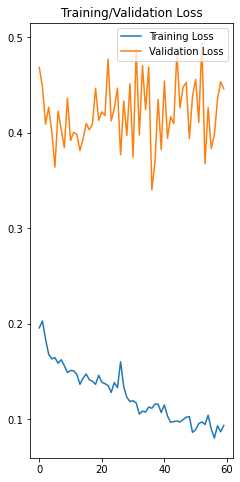

[array([[122.20543, 118.51982, 115.1313 , 119.92952]], dtype=float32), array([[222.80772, 220.54175, 219.75311, 222.6741 ]], dtype=float32), array([[237.77776, 237.29118, 237.21289, 236.81096]], dtype=float32), array([[253.4071 , 253.34187, 254.60469, 253.20697]], dtype=float32), array([[199.32701, 199.39688, 199.9601 , 198.53273]], dtype=float32), array([[274.51727, 274.20908, 274.79868, 274.00375]], dtype=float32), array([[266.16522, 265.91824, 266.09647, 266.1237 ]], dtype=float32), array([[139.30281, 137.39331, 135.22627, 136.93974]], dtype=float32), array([[237.86598, 236.19249, 235.43233, 237.4642 ]], dtype=float32), array([[301.25598, 300.29242, 300.38693, 301.44022]], dtype=float32), array([[247.22144, 245.8691 , 244.87643, 246.91664]], dtype=float32), array([[251.94205, 250.5655 , 250.61185, 251.85886]], dtype=float32), array([[302.94553, 301.97916, 302.7202 , 303.4594 ]], dtype=float32), array([[227.43056, 225.84657, 224.93973, 226.71982]], dtype=float32), array([[187.86128, 

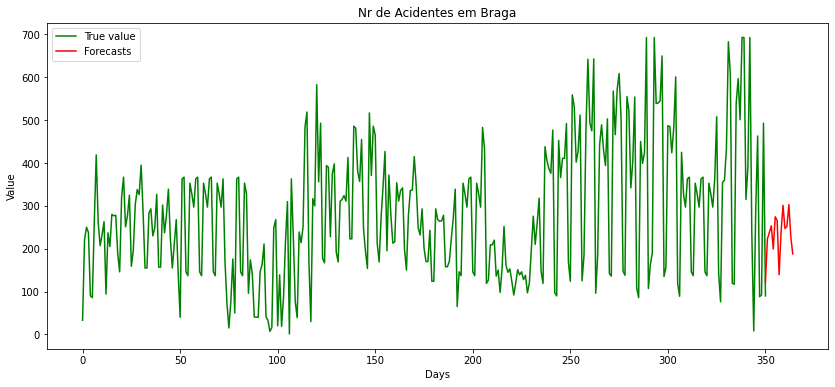

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 8, 64)             13440     
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
16/16 [==============================] - 5s 61ms/step - loss: 0.3131 - mae: 0.2694 - rmse: 0.3132 - val_l

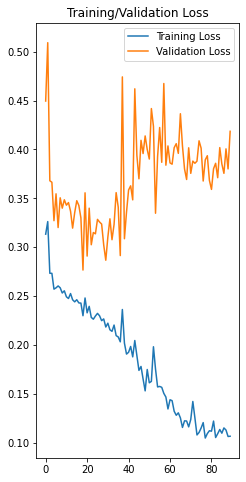

Epoch 1/90
31/31 [==============================] - 0s 14ms/step - loss: 0.2489 - mae: 0.2044 - rmse: 0.2490 - val_loss: 0.2567 - val_mae: 0.2336 - val_rmse: 0.2839
Epoch 2/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2394 - mae: 0.2004 - rmse: 0.2392 - val_loss: 0.2505 - val_mae: 0.2282 - val_rmse: 0.2852
Epoch 3/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2451 - mae: 0.2059 - rmse: 0.2451 - val_loss: 0.2517 - val_mae: 0.2307 - val_rmse: 0.2811
Epoch 4/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2176 - mae: 0.1838 - rmse: 0.2177 - val_loss: 0.2640 - val_mae: 0.2415 - val_rmse: 0.2924
Epoch 5/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2089 - mae: 0.1784 - rmse: 0.2088 - val_loss: 0.2507 - val_mae: 0.2259 - val_rmse: 0.2771

Epoch 00005: val_loss improved from 0.28658 to 0.25071, saving model to my_model_5_0.251.h5
Epoch 6/90
31/31 [==============================] - 0s 11ms/step - loss: 0.2085 - 

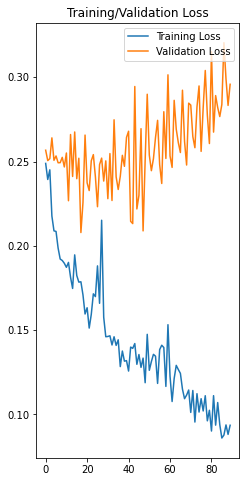

Epoch 1/90
47/47 [==============================] - 1s 26ms/step - loss: 0.1628 - mae: 0.1368 - rmse: 0.1643 - val_loss: 0.6192 - val_mae: 0.5331 - val_rmse: 0.6192
Epoch 2/90
47/47 [==============================] - 1s 11ms/step - loss: 0.1805 - mae: 0.1507 - rmse: 0.1790 - val_loss: 0.4414 - val_mae: 0.3535 - val_rmse: 0.4414
Epoch 3/90
47/47 [==============================] - 1s 12ms/step - loss: 0.1485 - mae: 0.1217 - rmse: 0.1476 - val_loss: 0.4386 - val_mae: 0.3526 - val_rmse: 0.4386
Epoch 4/90
47/47 [==============================] - 1s 12ms/step - loss: 0.1289 - mae: 0.1052 - rmse: 0.1278 - val_loss: 0.4866 - val_mae: 0.4043 - val_rmse: 0.4866
Epoch 5/90
47/47 [==============================] - 1s 12ms/step - loss: 0.1418 - mae: 0.1186 - rmse: 0.1398 - val_loss: 0.4597 - val_mae: 0.3820 - val_rmse: 0.4597

Epoch 00005: val_loss did not improve from 0.22187
Epoch 6/90
47/47 [==============================] - 1s 12ms/step - loss: 0.1357 - mae: 0.1099 - rmse: 0.1363 - val_loss: 0.

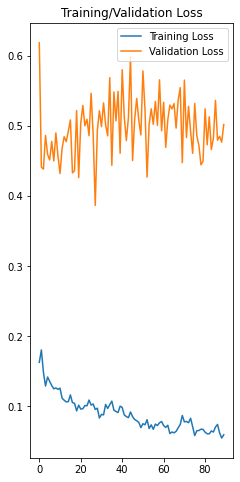

[array([[90.74244 , 90.26866 , 90.368645, 89.861374]], dtype=float32), array([[293.5909 , 293.72562, 293.67163, 293.4287 ]], dtype=float32), array([[243.56747, 243.37993, 243.3277 , 242.85606]], dtype=float32), array([[265.30862, 265.08054, 265.3087 , 264.9265 ]], dtype=float32), array([[323.1783 , 322.9166 , 323.23828, 323.21384]], dtype=float32), array([[359.97964, 359.81854, 360.03204, 360.12408]], dtype=float32), array([[200.69572, 200.61118, 200.98581, 200.55756]], dtype=float32), array([[164.96336, 164.73862, 164.84329, 164.54955]], dtype=float32), array([[259.11264, 258.7661 , 259.04202, 258.75122]], dtype=float32), array([[309.75558, 309.43115, 309.52878, 309.4961 ]], dtype=float32), array([[268.45172, 268.08203, 268.53555, 268.3323 ]], dtype=float32), array([[341.49564, 341.39697, 341.5536 , 341.6383 ]], dtype=float32), array([[340.04916, 339.78156, 340.0944 , 340.0133 ]], dtype=float32), array([[145.94276, 145.76659, 146.05728, 145.73242]], dtype=float32), array([[154.74457, 

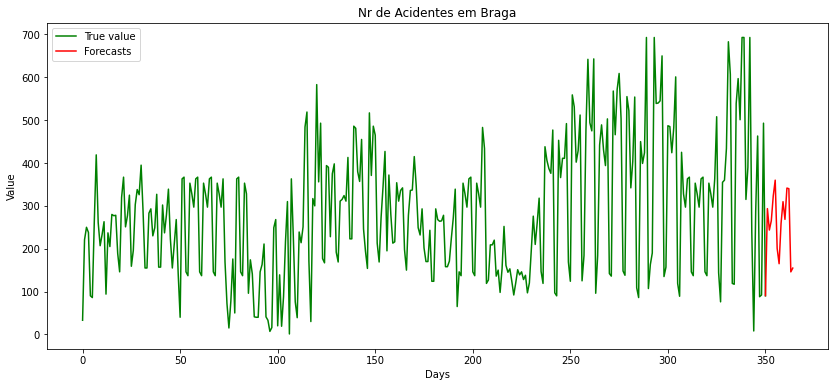

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 8, 64)             13440     
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
16/16 [==============================] - 4s 63ms/step - loss: 0.2785 - mae: 0.2391 - rmse: 0.2787 - val_

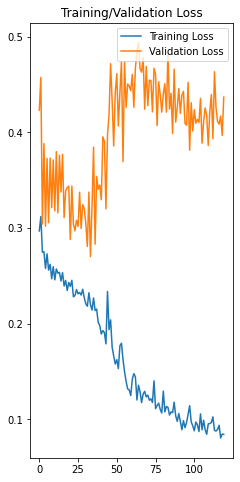

Epoch 1/120
31/31 [==============================] - 0s 14ms/step - loss: 0.2468 - mae: 0.2053 - rmse: 0.2476 - val_loss: 0.2733 - val_mae: 0.2564 - val_rmse: 0.3025
Epoch 2/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2291 - mae: 0.1926 - rmse: 0.2295 - val_loss: 0.2473 - val_mae: 0.2271 - val_rmse: 0.2777
Epoch 3/120
31/31 [==============================] - 0s 12ms/step - loss: 0.2046 - mae: 0.1739 - rmse: 0.2050 - val_loss: 0.2639 - val_mae: 0.2460 - val_rmse: 0.2890
Epoch 4/120
31/31 [==============================] - 0s 14ms/step - loss: 0.1906 - mae: 0.1606 - rmse: 0.1910 - val_loss: 0.2602 - val_mae: 0.2379 - val_rmse: 0.2904
Epoch 5/120
31/31 [==============================] - 0s 13ms/step - loss: 0.1883 - mae: 0.1586 - rmse: 0.1893 - val_loss: 0.2898 - val_mae: 0.2682 - val_rmse: 0.3188

Epoch 00005: val_loss improved from 0.30202 to 0.28980, saving model to my_model_5_0.290.h5
Epoch 6/120
31/31 [==============================] - 0s 13ms/step - loss: 0.1

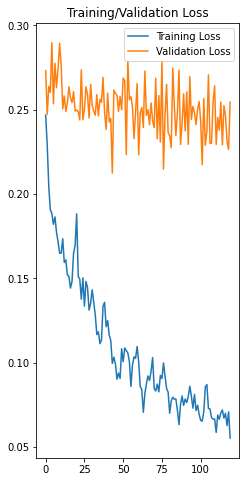

Epoch 1/120
47/47 [==============================] - 1s 29ms/step - loss: 0.1358 - mae: 0.1138 - rmse: 0.1348 - val_loss: 0.4438 - val_mae: 0.3586 - val_rmse: 0.4438
Epoch 2/120
47/47 [==============================] - 1s 13ms/step - loss: 0.1430 - mae: 0.1190 - rmse: 0.1412 - val_loss: 0.4372 - val_mae: 0.3654 - val_rmse: 0.4372
Epoch 3/120
47/47 [==============================] - 1s 13ms/step - loss: 0.1306 - mae: 0.1100 - rmse: 0.1297 - val_loss: 0.4401 - val_mae: 0.3759 - val_rmse: 0.4401
Epoch 4/120
47/47 [==============================] - 1s 12ms/step - loss: 0.1261 - mae: 0.1040 - rmse: 0.1246 - val_loss: 0.4604 - val_mae: 0.3942 - val_rmse: 0.4604
Epoch 5/120
47/47 [==============================] - 1s 13ms/step - loss: 0.1203 - mae: 0.0998 - rmse: 0.1201 - val_loss: 0.4632 - val_mae: 0.3925 - val_rmse: 0.4632

Epoch 00005: val_loss did not improve from 0.22919
Epoch 6/120
47/47 [==============================] - 1s 14ms/step - loss: 0.1127 - mae: 0.0909 - rmse: 0.1115 - val_lo

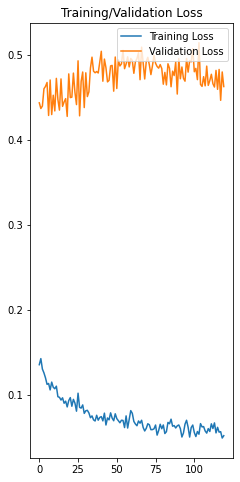

[array([[89.3075  , 89.39517 , 89.44526 , 89.311356]], dtype=float32), array([[282.98807, 282.98425, 282.99814, 282.9924 ]], dtype=float32), array([[244.33194, 244.3617 , 244.36238, 244.31886]], dtype=float32), array([[262.45795, 262.45425, 262.46298, 262.45633]], dtype=float32), array([[297.70483, 297.68634, 297.6956 , 297.7016 ]], dtype=float32), array([[294.19464, 294.20306, 294.21936, 294.18228]], dtype=float32), array([[156.22926, 156.27483, 156.31415, 156.23013]], dtype=float32), array([[187.53885, 187.56943, 187.58456, 187.53899]], dtype=float32), array([[314.05566, 314.06024, 314.07318, 314.0562 ]], dtype=float32), array([[312.54507, 312.51862, 312.51422, 312.5431 ]], dtype=float32), array([[302.2423 , 302.2166 , 302.20044, 302.22733]], dtype=float32), array([[361.81104, 361.80927, 361.79358, 361.79407]], dtype=float32), array([[247.45334, 247.46844, 247.47926, 247.45186]], dtype=float32), array([[123.94162, 123.97806, 124.01196, 123.95218]], dtype=float32), array([[271.43417, 

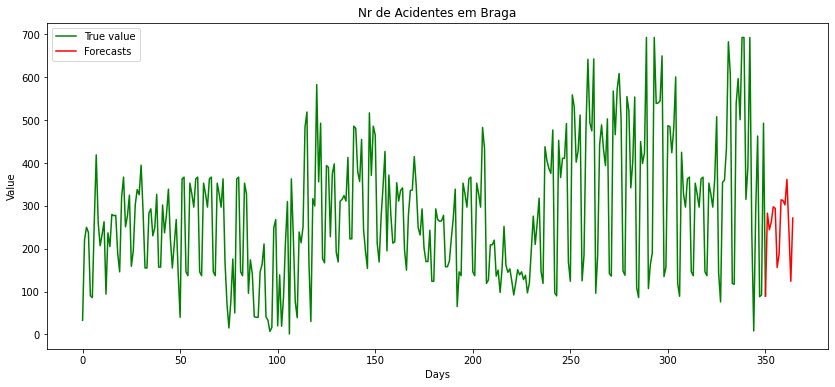

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 10, 64)            13440     
_________________________________________________________________
gru_13 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 4s 96ms/step - loss: 0.3682 - mae: 0.3073 - rmse: 0.3683 - val_l

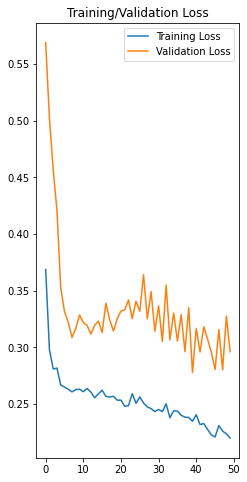

Epoch 1/50
20/20 [==============================] - 0s 18ms/step - loss: 0.3077 - mae: 0.2493 - rmse: 0.2998 - val_loss: 0.2895 - val_mae: 0.2316 - val_rmse: 0.2895
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 0.3022 - mae: 0.2531 - rmse: 0.2927 - val_loss: 0.2345 - val_mae: 0.1902 - val_rmse: 0.2345
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.2901 - mae: 0.2448 - rmse: 0.2816 - val_loss: 0.2813 - val_mae: 0.2472 - val_rmse: 0.2813
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 0.2832 - mae: 0.2400 - rmse: 0.2759 - val_loss: 0.2301 - val_mae: 0.1827 - val_rmse: 0.2301
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 0.2881 - mae: 0.2396 - rmse: 0.2783 - val_loss: 0.2667 - val_mae: 0.2348 - val_rmse: 0.2667

Epoch 00005: val_loss improved from 0.27792 to 0.26669, saving model to my_model_5_0.267.h5
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 0.2689 - 

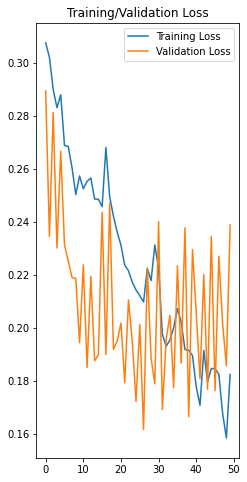

Epoch 1/50
29/29 [==============================] - 1s 17ms/step - loss: 0.2185 - mae: 0.1835 - rmse: 0.2198 - val_loss: 0.5169 - val_mae: 0.4833 - val_rmse: 0.4149
Epoch 2/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2292 - mae: 0.1909 - rmse: 0.2297 - val_loss: 0.4055 - val_mae: 0.3563 - val_rmse: 0.3393
Epoch 3/50
29/29 [==============================] - 0s 15ms/step - loss: 0.1930 - mae: 0.1586 - rmse: 0.1942 - val_loss: 0.4481 - val_mae: 0.4119 - val_rmse: 0.3634
Epoch 4/50
29/29 [==============================] - 0s 16ms/step - loss: 0.1900 - mae: 0.1579 - rmse: 0.1912 - val_loss: 0.4150 - val_mae: 0.3779 - val_rmse: 0.3313
Epoch 5/50
29/29 [==============================] - 0s 16ms/step - loss: 0.1809 - mae: 0.1496 - rmse: 0.1817 - val_loss: 0.4121 - val_mae: 0.3679 - val_rmse: 0.3465

Epoch 00005: val_loss did not improve from 0.17214
Epoch 6/50
29/29 [==============================] - 0s 15ms/step - loss: 0.1832 - mae: 0.1489 - rmse: 0.1846 - val_loss: 0.

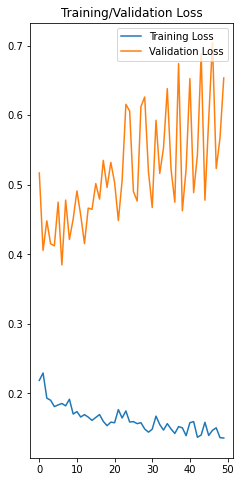

[array([[155.55603, 156.41368, 150.29   , 153.25175]], dtype=float32), array([[279.1356 , 281.51865, 277.22736, 276.0179 ]], dtype=float32), array([[278.86584, 279.37973, 278.88742, 277.44354]], dtype=float32), array([[217.5676 , 215.74019, 215.86076, 215.65958]], dtype=float32), array([[195.74556, 194.19899, 194.32736, 194.90665]], dtype=float32), array([[274.77338, 274.03882, 273.70493, 273.42618]], dtype=float32), array([[255.80444, 252.94142, 254.0312 , 254.1423 ]], dtype=float32), array([[219.17332, 215.76862, 216.03906, 216.6475 ]], dtype=float32), array([[258.62762, 256.5143 , 255.60031, 255.72992]], dtype=float32), array([[285.2874 , 282.71576, 282.0512 , 282.6905 ]], dtype=float32), array([[239.18445, 236.25136, 235.34135, 236.87253]], dtype=float32), array([[231.14313, 228.91634, 227.20665, 228.58086]], dtype=float32), array([[264.81982, 263.08966, 261.6713 , 262.25095]], dtype=float32), array([[255.41862, 253.03941, 251.95619, 253.03004]], dtype=float32), array([[237.59471, 

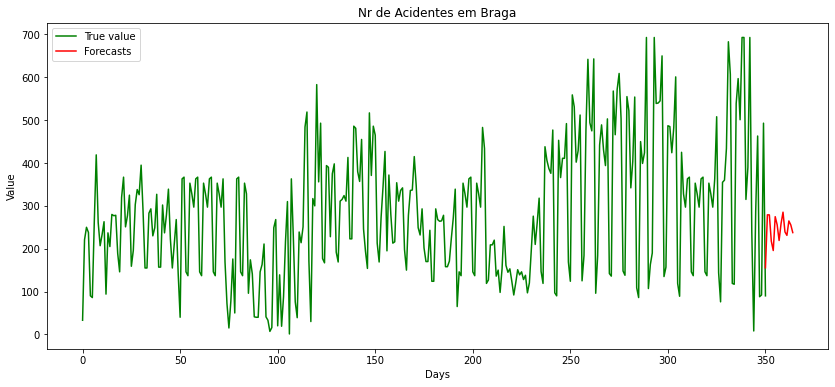

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 10, 64)            13440     
_________________________________________________________________
gru_15 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
10/10 [==============================] - 4s 97ms/step - loss: 0.2997 - mae: 0.2466 - rmse: 0.3002 - val_l

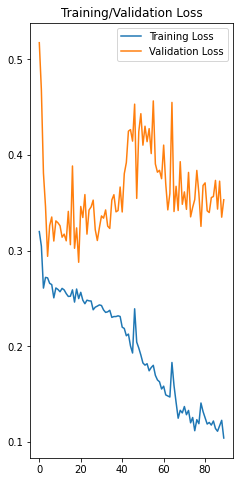

Epoch 1/90
20/20 [==============================] - 0s 19ms/step - loss: 0.2699 - mae: 0.2167 - rmse: 0.2612 - val_loss: 0.2209 - val_mae: 0.1893 - val_rmse: 0.2209
Epoch 2/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2684 - mae: 0.2274 - rmse: 0.2590 - val_loss: 0.2381 - val_mae: 0.2073 - val_rmse: 0.2381
Epoch 3/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2550 - mae: 0.2120 - rmse: 0.2475 - val_loss: 0.2423 - val_mae: 0.2204 - val_rmse: 0.2423
Epoch 4/90
20/20 [==============================] - 0s 16ms/step - loss: 0.2424 - mae: 0.2012 - rmse: 0.2361 - val_loss: 0.2046 - val_mae: 0.1843 - val_rmse: 0.2046
Epoch 5/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2376 - mae: 0.1957 - rmse: 0.2299 - val_loss: 0.2305 - val_mae: 0.2124 - val_rmse: 0.2305

Epoch 00005: val_loss improved from 0.28788 to 0.23048, saving model to my_model_5_0.230.h5
Epoch 6/90
20/20 [==============================] - 0s 19ms/step - loss: 0.2234 - 

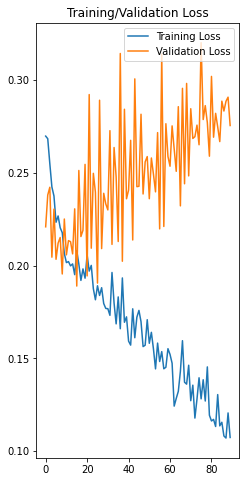

Epoch 1/90
29/29 [==============================] - 0s 17ms/step - loss: 0.1907 - mae: 0.1592 - rmse: 0.1917 - val_loss: 0.5089 - val_mae: 0.4497 - val_rmse: 0.4713
Epoch 2/90
29/29 [==============================] - 0s 16ms/step - loss: 0.1836 - mae: 0.1458 - rmse: 0.1841 - val_loss: 0.4809 - val_mae: 0.4334 - val_rmse: 0.4707
Epoch 3/90
29/29 [==============================] - 0s 16ms/step - loss: 0.1533 - mae: 0.1223 - rmse: 0.1542 - val_loss: 0.5048 - val_mae: 0.4494 - val_rmse: 0.4791
Epoch 4/90
29/29 [==============================] - 0s 16ms/step - loss: 0.1518 - mae: 0.1225 - rmse: 0.1528 - val_loss: 0.5095 - val_mae: 0.4760 - val_rmse: 0.5145
Epoch 5/90
29/29 [==============================] - 0s 17ms/step - loss: 0.1708 - mae: 0.1401 - rmse: 0.1713 - val_loss: 0.4713 - val_mae: 0.4065 - val_rmse: 0.4360

Epoch 00005: val_loss did not improve from 0.22514
Epoch 6/90
29/29 [==============================] - 0s 17ms/step - loss: 0.1522 - mae: 0.1209 - rmse: 0.1529 - val_loss: 0.

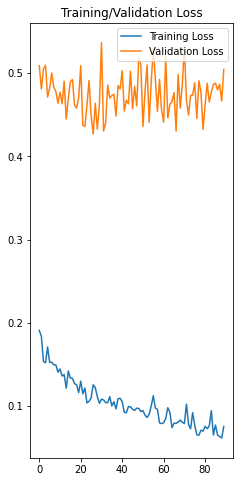

[array([[217.2338 , 217.32654, 216.8257 , 216.79022]], dtype=float32), array([[323.91385, 323.63464, 323.2781 , 323.5247 ]], dtype=float32), array([[328.30194, 329.25348, 328.38525, 328.91748]], dtype=float32), array([[281.16095, 281.57278, 280.96735, 281.49542]], dtype=float32), array([[234.99843, 234.98822, 234.94226, 234.8237 ]], dtype=float32), array([[231.11836, 230.88506, 230.9645 , 231.0715 ]], dtype=float32), array([[207.96765, 207.77094, 207.88742, 207.9244 ]], dtype=float32), array([[223.14044, 223.21198, 223.36078, 223.11723]], dtype=float32), array([[303.29572, 303.60223, 303.80124, 303.62952]], dtype=float32), array([[243.36023, 243.46921, 243.26237, 243.53033]], dtype=float32), array([[234.5005 , 234.21281, 234.64229, 234.49901]], dtype=float32), array([[262.1743 , 261.42496, 262.20447, 262.0162 ]], dtype=float32), array([[204.98358, 204.32175, 204.9313 , 204.73932]], dtype=float32), array([[204.6945 , 204.32022, 204.72258, 204.52988]], dtype=float32), array([[272.72183, 

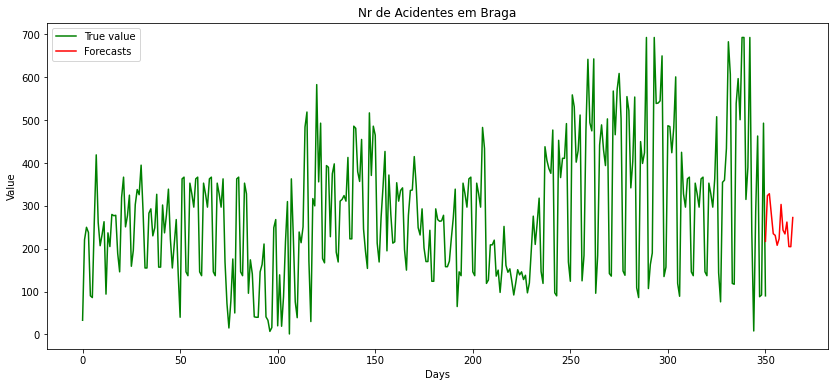

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 10, 64)            13440     
_________________________________________________________________
gru_17 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
Total params: 25,220
Trainable params: 25,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
10/10 [==============================] - 5s 101ms/step - loss: 0.2952 - mae: 0.2462 - rmse: 0.2958 - val

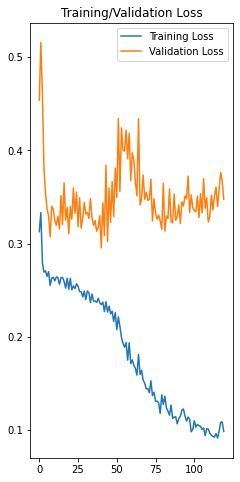

Epoch 1/120
20/20 [==============================] - 0s 18ms/step - loss: 0.2863 - mae: 0.2278 - rmse: 0.2747 - val_loss: 0.2463 - val_mae: 0.2144 - val_rmse: 0.2463
Epoch 2/120
20/20 [==============================] - 0s 16ms/step - loss: 0.2655 - mae: 0.2177 - rmse: 0.2615 - val_loss: 0.2544 - val_mae: 0.2203 - val_rmse: 0.2544
Epoch 3/120
20/20 [==============================] - 0s 17ms/step - loss: 0.2462 - mae: 0.2050 - rmse: 0.2369 - val_loss: 0.2276 - val_mae: 0.2041 - val_rmse: 0.2276
Epoch 4/120
20/20 [==============================] - 0s 16ms/step - loss: 0.2328 - mae: 0.1939 - rmse: 0.2243 - val_loss: 0.2107 - val_mae: 0.1861 - val_rmse: 0.2107
Epoch 5/120
20/20 [==============================] - 0s 17ms/step - loss: 0.2267 - mae: 0.1865 - rmse: 0.2193 - val_loss: 0.2167 - val_mae: 0.1937 - val_rmse: 0.2167

Epoch 00005: val_loss improved from 0.30239 to 0.21673, saving model to my_model_5_0.217.h5
Epoch 6/120
20/20 [==============================] - 0s 16ms/step - loss: 0.2

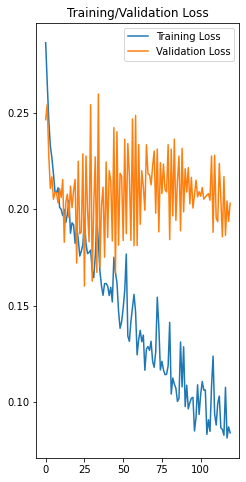

Epoch 1/120
29/29 [==============================] - 0s 17ms/step - loss: 0.1552 - mae: 0.1293 - rmse: 0.1573 - val_loss: 0.6246 - val_mae: 0.5628 - val_rmse: 0.5650
Epoch 2/120
29/29 [==============================] - 0s 16ms/step - loss: 0.1788 - mae: 0.1461 - rmse: 0.1802 - val_loss: 0.5565 - val_mae: 0.5098 - val_rmse: 0.5196
Epoch 3/120
29/29 [==============================] - 0s 16ms/step - loss: 0.1323 - mae: 0.1070 - rmse: 0.1344 - val_loss: 0.5964 - val_mae: 0.5348 - val_rmse: 0.5448
Epoch 4/120
29/29 [==============================] - 0s 17ms/step - loss: 0.1309 - mae: 0.1067 - rmse: 0.1326 - val_loss: 0.6077 - val_mae: 0.5394 - val_rmse: 0.5396
Epoch 5/120
29/29 [==============================] - 0s 16ms/step - loss: 0.1253 - mae: 0.1038 - rmse: 0.1273 - val_loss: 0.5404 - val_mae: 0.5019 - val_rmse: 0.5075

Epoch 00005: val_loss did not improve from 0.18109
Epoch 6/120
29/29 [==============================] - 0s 17ms/step - loss: 0.1261 - mae: 0.1044 - rmse: 0.1276 - val_lo

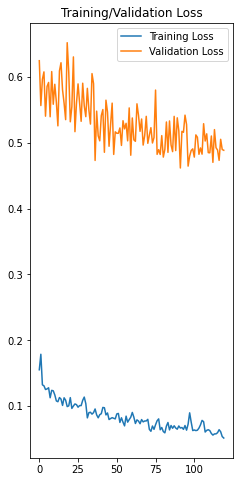

[array([[176.43268, 176.14067, 176.07805, 176.40385]], dtype=float32), array([[273.21204, 273.46835, 273.24258, 273.33237]], dtype=float32), array([[291.3519 , 291.60132, 291.2172 , 291.3455 ]], dtype=float32), array([[198.68135, 198.58612, 198.64325, 198.63362]], dtype=float32), array([[256.89233, 256.7274 , 256.88608, 256.68594]], dtype=float32), array([[321.59753, 321.69556, 321.44354, 321.62122]], dtype=float32), array([[181.84013, 182.01962, 181.80312, 181.95409]], dtype=float32), array([[159.0676 , 158.99178, 159.107  , 158.99731]], dtype=float32), array([[372.19626, 372.60526, 372.20178, 372.284  ]], dtype=float32), array([[305.64368, 305.9691 , 305.54367, 305.72275]], dtype=float32), array([[263.56998, 263.72806, 263.62335, 263.3924 ]], dtype=float32), array([[307.81137, 308.1926 , 307.92862, 307.6219 ]], dtype=float32), array([[278.60492, 278.6385 , 278.55902, 278.37357]], dtype=float32), array([[178.81232, 178.65579, 178.83044, 178.60951]], dtype=float32), array([[226.04967, 

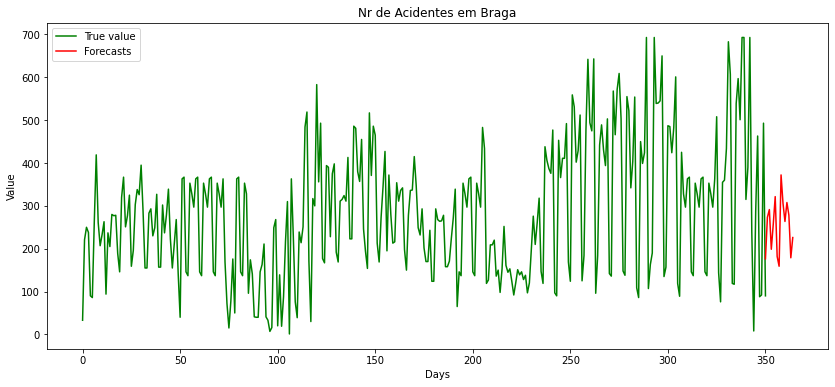

In [ ]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [ ]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [ ]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.2786297788222631, 0.237408913175265, 0.2798760404189428, 0.3485479424397151, 0.3049178044001261, 0.34834533135096235] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.2017081171274185, 0.16659619564811387, 0.20242461219429972, 0.30694580415884654, 0.2566781109571457, 0.30580156405766806] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.1375402856369813, 0.11353904031217098, 0.13789087555060783, 0.3805028148492178, 0.30790647958715756, 0.3827506725490093] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.17498840668963064, 0.14811187001566092, 0.1757175377673573, 0.3442842160662016, 0.2892105771435632, 0.3544169844852554] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.1388152871142935, 0.11587644666433335, 0.13900939064721266, 0.37535276595089173, 0.319431663663299, 0.38528120495654

In [ ]:
pd.DataFrame.from_dict(final_dict, orient='index',columns=['Loss', 'MAE', 'RMSE', 'VAL_LOSS', 'VAL_MAE', 'VAL_RMSE'])

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.278630,0.237409,0.279876,0.348548,0.304918,0.348345
2,0.201708,0.166596,0.202425,0.306946,0.256678,0.305802
3,0.137540,0.113539,0.137891,0.380503,0.307906,0.382751
4,0.174988,0.148112,0.175718,0.344284,0.289211,0.354417
5,0.138815,0.115876,0.139009,0.375353,0.319432,0.385281
6,0.115088,0.096266,0.115116,0.374538,0.322031,0.387241
7,0.213195,0.178529,0.212379,0.354057,0.303959,0.323253
8,0.156389,0.128901,0.155413,0.362398,0.309559,0.352261
9,0.137093,0.112988,0.136180,0.362304,0.312437,0.341142
